In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from defined_methods import merge_csv, merge_csv_flow

# Data preparation

In [2]:
# read the administrative relationship encoding file
admin_rel = pd.read_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/oa_lsoa_msoa_la_trans.csv')
admin_rel

,oa21cd,lsoa21cd,msoa21cd,lad21cd,lad21nm
0,E00060255,E01011950,E02002490,E06000001,Hartlepool
1,E00060256,E01011949,E02002491,E06000001,Hartlepool
2,E00060257,E01011949,E02002491,E06000001,Hartlepool
3,E00060258,E01011951,E02002489,E06000001,Hartlepool
4,E00060259,E01011951,E02002489,E06000001,Hartlepool
...,...,...,...,...,...
178600,E00175269,E01033602,E02000968,E09000033,Westminster
178601,E00175270,E01033602,E02000968,E09000033,Westminster
178602,E00175271,E01033598,E02000968,E09000033,Westminster
178603,E00175272,E01033598,E02000968,E09000033,Westminster


(500648.6269499996, 564876.9020499996, 153596.6433500004, 203188.04565000077)

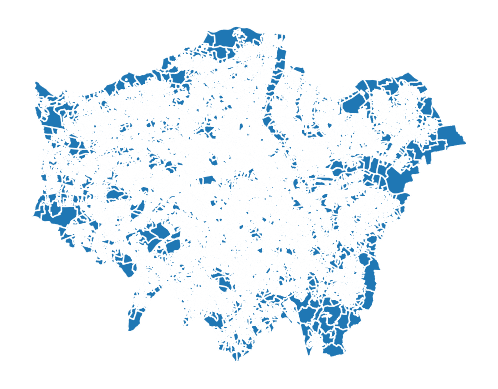

In [3]:
# read the spatial administrative boundary files
oa = gpd.read_file('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_oa.gpkg')
lsoa = gpd.read_file('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_lsoa.gpkg')
msoa = gpd.read_file('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_msoa.gpkg')
oa.plot()
plt.axis('off')


## Individual

In [8]:
device = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/device')
stay_time = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/stay time')
travel_time = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/travel time')
# drop the na values in the stay time dataset
stay_time= stay_time.dropna()
# convert the stay time from seconds to hours
stay_time['stay_time'] = stay_time['stay_time'].astype(int)/3600


In [9]:
# Filtering for March 1, 2022, and March 3, 2022

device_313 = device[(device['date'] == '03/01/22') | (device['date'] == '03/03/22') ].copy().reset_index(drop=True)
device_313['date'] = pd.to_datetime(device_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

stay_time_313 = stay_time[(stay_time['date'] == '03/01/22') | (stay_time['date'] == '03/03/22')].copy().reset_index(drop=True)
stay_time_313['date'] = pd.to_datetime(stay_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')


travel_time_313 = travel_time[(travel_time['date'] == '03/01/22') | (travel_time['date'] == '03/03/22')].copy().reset_index(drop=True)
travel_time_313['date'] = pd.to_datetime(travel_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

In [ ]:
#Print the dfs basic preview 
print('Device'+'-'*50)
print(device_313.info())
print(device_313['startid'].nunique())
print(device_313['device_type'].unique())
print(device_313['startid'].duplicated().sum()/device['startid'].nunique())
print(device_313.head())

print('Stay time'+'-'*50)
print(stay_time_313.info())
print(device['startid'].nunique())
print(stay_time_313.head())
print('Travel time'+'-'*50)
print(stay_time_313.info())
print(device['startid'].nunique())
print(stay_time_313.head())

### Device behavioural test

In [10]:
# Device related behavioral test
test_device_lable = device_313['startid'].unique()[0]
# print(test_device_lable)
test_device = device_313[device_313['startid'] == test_device_lable]
# print(test_device)
test_device_stay = stay_time_313[stay_time_313['startid'] == test_device_lable]
# print(test_device_stay)
test_device_modes = stay_time_313[stay_time_313['startid'] == test_device_lable]
# print(test_device_travel)
# merge the test device status, stay time and travel time
test_device_status = pd.merge(test_device, test_device_stay, on=['startid', 'date','oa21cd','device_type'], how='left')
test_device = test_device.drop_duplicates().reset_index(drop=True)
test_device_status

,startid,oa21cd,device_type,date,stay_time
0,1000015989590377328043415348373664771294182405...,E00018694,resident,03/01/22,8.21
1,1000015989590377328043415348373664771294182405...,E00018691,passthrough,03/01/22,NaN
2,1000015989590377328043415348373664771294182405...,E00018688,passthrough,03/01/22,NaN


In [11]:
test_device_modes

,startid,oa21cd,device_type,stay_time,date
0,1000015989590377328043415348373664771294182405...,E00018694,resident,8.21,03/01/22


### Device behaviour calculation

In [12]:
device_313_status = pd.merge(device_313, stay_time_313, on=['startid', 'date','oa21cd','device_type'], how='left')
device_313_status = device_313_status.drop_duplicates().reset_index(drop=True)
device_313_modes = travel_time_313.groupby(['startid', 'date','update_mode']).agg({'time':'sum','distance':'sum'}).reset_index()

In [13]:
device_313_status

,startid,oa21cd,device_type,date,stay_time
0,1000015989590377328043415348373664771294182405...,E00018694,resident,03/01/22,8.210000
1,1000037686428573366468895824408367961791352836...,E00008360,resident,03/01/22,18.706667
2,1000056811909521100485295490854336441641125953...,E00013578,resident,03/01/22,4.663889
3,1000064961804232476337777826703284484305799106...,E00007278,resident,03/01/22,23.500278
4,1000071212051388806025932869511590862120065353...,E00008696,resident,03/01/22,23.540278
...,...,...,...,...,...
5186279,9999850430322788483675034814525089294618926457...,E00001327,passthrough,03/03/22,NaN
5186280,9999850430322788483675034814525089294618926457...,E00001313,passthrough,03/03/22,NaN
5186281,9999850430322788483675034814525089294618926457...,E00001315,passthrough,03/03/22,NaN
5186282,9999901429782413329877307004404125705010246950...,E00003508,passthrough,03/03/22,NaN


In [14]:
device_313_modes

,startid,date,update_mode,time,distance
0,1000015989590377328043415348373664771294182405...,03/01/22,stationary,8.210000,0.463290
1,1000015989590377328043415348373664771294182405...,03/01/22,walks,0.794722,1.538798
2,1000019095294824105134361584772501836692863196...,03/03/22,car,1.290000,25.116099
3,1000028657842442300682644984592003172585780131...,03/01/22,stationary,9.001111,0.144152
4,1000028657842442300682644984592003172585780131...,03/01/22,walks,2.950833,3.310107
...,...,...,...,...,...
540723,9999901429782413329877307004404125705010246950...,03/01/22,walks,11.122222,9.387030
540724,9999901429782413329877307004404125705010246950...,03/03/22,stationary,20.062778,0.479775
540725,9999901429782413329877307004404125705010246950...,03/03/22,walks,3.576389,9.816912
540726,9999986042492829152298314924974521522262434004...,03/01/22,stationary,23.807222,0.303220


## System

In [7]:
traffic_flows = merge_csv_flow(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'

inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
# tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
# tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})
road_network.rename(columns={'NAME': 'boroughs'}, inplace=True)
road_network.loc[:, ['cycle_lane', 'bus_lane']] = road_network[['cycle_lane', 'bus_lane']].fillna('n')

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()
traffic_flows['total'] = traffic_flows['bus'] + traffic_flows['car'] + traffic_flows['cycle'] + traffic_flows[
    'walks'] + traffic_flows['stationary']

flows = pd.merge(
    road_network[
        ['toid', 'roadclassi', 'geometry', 'cycle_lane', 'bus_lane', 'boroughs', 'directiona', 'length', 'roadwidtha',
         'elevationg']],
    traffic_flows, left_on='toid', right_on='toid', how='left')
flows.set_geometry('geometry', inplace=True)

flows['classification'] = flows['roadclassi'].replace(
    {'Unknown': 'Local Road', 'Not Classified': 'Local Road', 'Unclassified': 'Local Road',
     'Classified Unnumbered': 'Local Road', 'A Road': 'Strategic Road', 'B Road': 'Strategic Road'})

flows.drop(columns=['roadclassi'], inplace=True)

stage_date = ['03/01/22', '02/22/22', '03/08/22']
flows = flows.loc[flows['date'].isin(stage_date)]

# label the regional level
flows = gpd.sjoin(flows, inoutter, how='inner', predicate='within')
flows = flows.drop(columns=['index_right', 'Source', 'Area_Ha', 'Shape_Leng', 'Shape_Area'])
flows.reset_index(drop=True, inplace=True)

regression = flows

# convert the dataframe
flows = pd.melt(flows,
                id_vars=['toid', 'classification', 'geometry', 'date', 'Boundary', 'cycle_lane', 'bus_lane',
                         'boroughs', 'directiona', 'length', 'roadwidtha', 'elevationg'],
                var_name='mode', value_name='flow')

flows = pd.pivot_table(flows,
                       index=['toid', 'classification', 'geometry', 'Boundary', 'mode', 'cycle_lane', 'bus_lane',
                              'boroughs', 'directiona', 'length', 'roadwidtha', 'elevationg'],
                       columns='date',
                       values='flow',
                       aggfunc='first').reset_index()

flows = flows.groupby(
    ['toid', 'mode', 'classification', 'geometry', 'Boundary', 'cycle_lane', 'bus_lane', 'boroughs', 'directiona',
     'length', 'roadwidtha', 'elevationg'],
    as_index=False).agg(
    {'03/01/22': 'first', '02/22/22': 'first', '03/08/22': 'first'})
# Calculate the impact and recovery flows for one strike
flows['impact_flow'] = flows['03/01/22'] - flows['02/22/22']
flows['recovery_flow'] = flows['03/08/22'] - flows['03/01/22']

# Calculate impact rate while avoiding division by zero
flows['impact_rate'] = flows.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
flows['recovery_rate'] = flows.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

speed = merge_csv_flow(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/Traffic flow with speed')
speed = speed.groupby(['travel_mode', 'toid', 'date']).agg({'speed_overall': 'mean'}).reset_index()
speed = speed.pivot(index=['toid', 'travel_mode'], columns='date', values='speed_overall').reset_index()
speed.rename(columns={'03/01/22': 'speed_03/01/22', '02/22/22': 'speed_02/22/22', '03/08/22': 'speed_03/08/22'},
             inplace=True)

columns_to_sum = ['speed_03/01/22', 'speed_02/22/22', 'speed_03/08/22']
toid_mode_totals = speed.groupby(['toid', 'travel_mode'])[columns_to_sum].sum().reset_index()

# 创建一个包含 'total' 行的 DataFrame
total_row = toid_mode_totals.groupby('toid')[columns_to_sum].sum().reset_index()
total_row['travel_mode'] = 'total'

speed = pd.concat([toid_mode_totals, total_row], ignore_index=True)

# Calculate the impact and recovery flows for one strike
speed['impact_speed'] = speed['speed_03/01/22'] - speed['speed_02/22/22']
speed['recovery_speed'] = speed['speed_03/08/22'] - speed['speed_03/01/22']

speed['impact_speed_rate'] = speed.apply(
    lambda row: round(row['impact_speed'] / row['speed_02/22/22'], 4) if row['speed_02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
speed['recovery_speed_rate'] = speed.apply(
    lambda row: round(row['recovery_speed'] / row['speed_03/01/22'], 4) if row['speed_03/01/22'] != 0 else 0, axis=1)
flows = pd.merge(flows, speed, left_on=['toid', 'mode'], right_on=['toid', 'travel_mode'], how='left')
flows.drop(columns=['travel_mode'], inplace=True)

All = flows.copy()
All


date,toid,mode,classification,geometry,Boundary,cycle_lane,bus_lane,boroughs,directiona,length,...,recovery_flow,impact_rate,recovery_rate,speed_03/01/22,speed_02/22/22,speed_03/08/22,impact_speed,recovery_speed,impact_speed_rate,recovery_speed_rate
0,osgb4000000027865921,bus,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,inOppositeDirection,2904.80,...,-4,0.4545,-0.2500,1.866527,1.691628,1.966679,0.174899,0.100152,0.1034,0.0537
1,osgb4000000027865921,car,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,inOppositeDirection,2904.80,...,40,-0.0536,0.0384,1.699271,1.998224,1.852627,-0.298953,0.153356,-0.1496,0.0902
2,osgb4000000027865921,cycle,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,inOppositeDirection,2904.80,...,-7,2.5000,-0.5000,1.884427,1.883744,1.727556,0.000683,-0.156872,0.0004,-0.0832
3,osgb4000000027865921,stationary,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,inOppositeDirection,2904.80,...,-1,0.0000,-0.5000,1.004754,0.000000,0.000000,1.004754,-1.004754,0.0000,-1.0000
4,osgb4000000027865921,total,Motorway,"LINESTRING (531539.442 200769.874, 531592.988 ...",Outer London,n,n,Enfield,inOppositeDirection,2904.80,...,27,-0.0487,0.0247,6.721938,5.940743,6.116473,0.781195,-0.605465,0.1315,-0.0901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487323,osgb5000005242182149,car,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,bothDirections,26.28,...,18,-0.3889,0.5455,0.354515,0.357080,0.343335,-0.002565,-0.011180,-0.0072,-0.0315
1487324,osgb5000005242182149,cycle,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,bothDirections,26.28,...,-1,1.0000,-0.5000,0.000000,0.264922,0.585180,-0.264922,0.585180,-1.0000,0.0000
1487325,osgb5000005242182149,stationary,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,bothDirections,26.28,...,2,-0.2500,0.6667,0.000107,0.000151,0.000061,-0.000044,-0.000046,-0.2902,-0.4319
1487326,osgb5000005242182149,total,Local Road,"LINESTRING (543548.945 179236.408, 543554.000 ...",Inner London,n,n,Greenwich,bothDirections,26.28,...,20,-0.3243,0.4000,0.773392,0.661585,1.025616,0.111807,0.252224,0.1690,0.3261


# Indicators building

## Individual

### Trip distance

### Trip time

### Trip rate

### Travel time

### Travel distance